In [62]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase import Atoms
from ase.build import mx2, molecule
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.calculators.espresso import Espresso, EspressoProfile
from ase.optimize import QuasiNewton
from ase.visualize import view

import time
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal,eV

In [2]:
# Source all important path for LIB and excutable path.
import os
os.environ['LD_LIBRARY_PATH'] ="/opt/packages/oneapi/v2023.2.0/mkl/2023.2.0/lib/intel64:/opt/packages/oneapi/v2023.2.0/compiler/2023.2.1/linux/lib:/opt/packages/oneapi/v2023.2.0/compiler/2023.2.1/linux/lib/x64:/opt/packages/oneapi/v2023.2.0/compiler/2023.2.1/linux/compiler/lib/intel64_lin:/opt/packages/oneapi/v2023.2.0/tbb/2021.10.0/lib/intel64/gcc4.8:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/libfabric/lib:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/lib/release:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/lib"
os.environ['PATH'] ="/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/libfabric/bin:/opt/packages/oneapi/v2023.2.0/mpi/2021.10.0/bin:/opt/packages/psc.allocations.user/bin:/opt/packages/allocations/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/packages/interact/bin:/opt/puppetlabs/bin:/ocean/projects/che240027p/shared/software/Team_BSU_Soft/q-e/bin"


In [101]:
## Load the crystal structure (Crystallography Open Database) from local file
RuO2_bulk = read("./structure/RuO2.cif")
view(RuO2_bulk, viewer="x3d")

/ocean/projects/che240027p/shared/software/Team_BSU_Soft/qms2024-BSU/lib/python3.8/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(136, setting=1). This may result in wrong setting!
  warnings.warn(


In [37]:
# Define basic commands and pseudodir
runprefix = "mpirun -np 32 "
qepath = " "
pseudodir = "./pseudos"

# Optionally create profile to override paths in ASE configuration:
profile = EspressoProfile(
    command=runprefix+qepath+'pw.x', pseudo_dir=pseudodir
)

In [ ]:
# Download the pseudopotentials for Ru and O
!wget https://www.physics.rutgers.edu/gbrv/ru_pbesol_v1.2.uspp.F.UPF
!wget https://www.physics.rutgers.edu/gbrv/o_pbesol_v1.2.uspp.F.UPF
!mv *.F.UPF pseudos

pseudopotentials = {
    "O":"o_pbesol_v1.2.uspp.F.UPF",
    "Ru":"ru_pbesol_v1.2.uspp.F.UPF"
}

## Optimized K-points

Here the convergence of K-points are tested. Currently Ecut_wfc = 50, Ecut_rho = 400

In [39]:
Ecut_wfc = 50
Ecut_rho = Ecut_wfc*8
K_num = 1
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': Ecut_wfc,
        'ecutrho': Ecut_rho,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
} 




In [44]:
# K points = 1,2,4,8,16,18,20,24
from copy import deepcopy
K_conv = []
for k in [1,2,4,8,16,18,20,24]:
    # Update the k value in calculator
    calc = Espresso(
        profile=profile,
        pseudopotentials=pseudopotentials,
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        input_data=input_data,
        kpts=(k,k,k),
        koffset=(0,0,0))
    
    
    RuO2_bulk.calc = deepcopy(calc)
    
    eRuO2_bulk = RuO2_bulk.get_potential_energy()
    K_conv.append([k, eRuO2_bulk])
    if os.path.isfile("espresso.pwo"): os.remove("espresso.pwo")
    print(f'{k}: {eRuO2_bulk:.8f}')

1: -7036.61600676
2: -7038.62910779
4: -7038.32105030
8: -7038.31162714
16: -7038.31147530
18: -7038.31150482
20: -7038.31148523
24: -7038.31149067


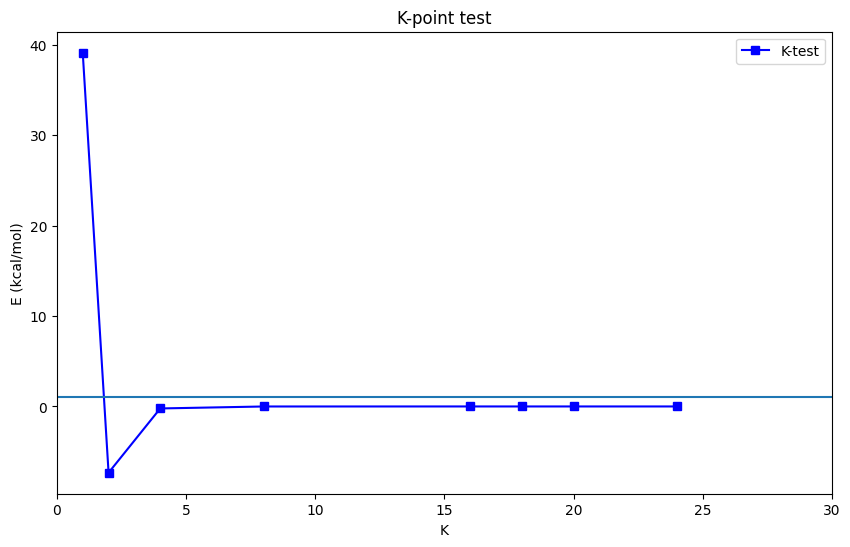

In [64]:
K_conv = np.array(K_conv)
# Create a figure and a set of subplots
fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
ax.plot(K_conv[:,0], (K_conv[:,1]-K_conv[-1,1])*mol/kcal,'-s', label='K-test', color='blue')

ax.hlines(1,xmin=-1,xmax=30)
ax.set_xlim(0,30)
ax.set_title('K-point test')
ax.set_xlabel('K')
ax.set_ylabel('E (kcal/mol)')
ax.legend()

K-points (4,4,4) is good. 

## Optimize the Ecut_wfc with (Ecut_rho = Ecut_wfc*8)

In [136]:
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 50,
        'ecutrho': 400,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
}


E_wfc2 =[] 
for Ecut_wfc in [20,25,30,35,40,45,50,55,60,70,80,90,100]:
    
    input_data['system']['ecutwfc'] = Ecut_wfc
    input_data['system']['ecutrho'] = Ecut_wfc*8
    calc = Espresso(
        profile=profile,
        pseudopotentials=pseudopotentials,
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        input_data=input_data,
        kpts=(4,4,4),
        koffset=(0,0,0))
    
    RuO2_bulk.calc = deepcopy(calc)
    
    
    eRuO2_bulk = RuO2_bulk.get_potential_energy()
    #if os.path.isfile("espresso.pwo"): os.remove("espresso.pwo")
    print(f'{Ecut_wfc}: {eRuO2_bulk:.8f}')
    E_wfc2.append([Ecut_wfc,eRuO2_bulk])



20: -7011.05573007
25: -7032.91029506
30: -7037.56437301
35: -7038.22462908
40: -7038.28889964
45: -7038.30341256
50: -7038.32105030
55: -7038.33689195
60: -7038.34684112
70: -7038.35248653
80: -7038.35857126
90: -7038.36932820
100: -7038.37581838


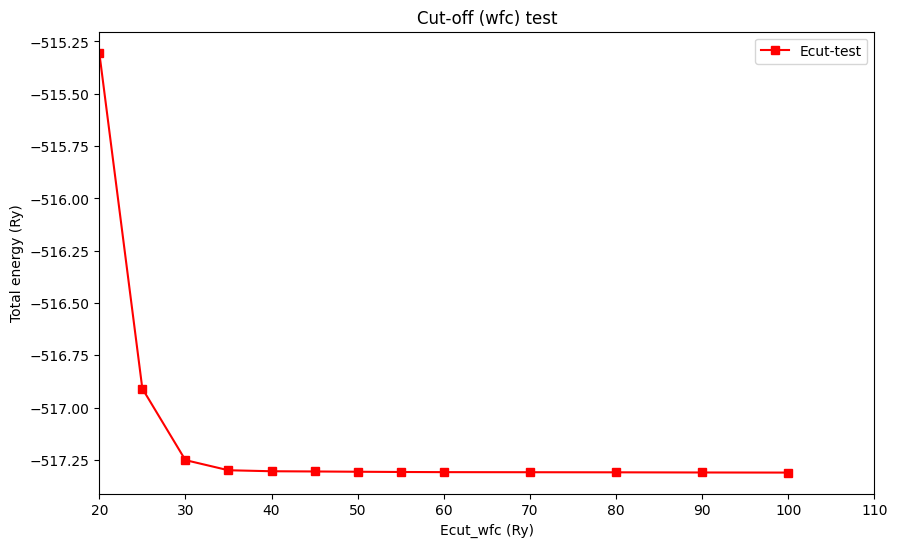

In [155]:
E_wfc = np.array(E_wfc)
E_wfc2 = np.array(E_wfc2)
K_conv = np.array(K_conv)
# Create a figure and a set of subplots
fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
#ax.plot(E_wfc[:,0], E_wfc[:,1]-E_wfc[-1,1],'-s', label='Ecut-test', color='blue')
ax.plot(E_wfc2[:,0], E_wfc2[:,1]/Rydberg,'-s', label='Ecut-test', color='red')


ax.set_xlim(20,110)
#ax.set_ylim(-1,4)
ax.set_title('Cut-off (wfc) test')
ax.set_xlabel('Ecut_wfc (Ry)')
ax.set_ylabel(r'Total energy (Ry)')
ax.legend()

In [145]:
for i,j,k in zip(E_wfc2[:,0], E_wfc2[:,1],E_wfc2[:,1]-np.roll(E_wfc2[:,1],1)):
    print(i, j, k/4)

20.0 -7011.055730072685 6.830022077500416
25.0 -7032.910295060395 -5.463641246927409
30.0 -7037.56437301102 -1.163519487656231
35.0 -7038.224629076734 -0.16506401642868695
40.0 -7038.288899644286 -0.016067641887957507
45.0 -7038.303412563758 -0.0036282298678997904
50.0 -7038.321050302494 -0.004409434684021107
55.0 -7038.33689195384 -0.0039604128364771896
60.0 -7038.346841116065 -0.00248729055624608
70.0 -7038.352486525819 -0.0014113524384811171
80.0 -7038.358571263365 -0.0015211843865472474
90.0 -7038.369328195522 -0.002689233039291139
100.0 -7038.375818382687 -0.0016225467911681335


## Optimize the Ecut_rho with Ecut_rho = 40

In [158]:
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 40,
        'ecutrho': 320,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
}


E_rho =[] 
Ecut_wfc = 40
for alpha in [3,4,5,6,7, 8, 9, 10, 11, 12, 13]:
    
    input_data['system']['ecutwfc'] = Ecut_wfc
    input_data['system']['ecutrho'] = Ecut_wfc*alpha
    calc = Espresso(
        profile=profile,
        pseudopotentials=pseudopotentials,
        tstress=True,  # deprecated, put in input_data
        tprnfor=True,  # deprecated, put in input_data
        input_data=input_data,
        kpts=(4,4,4),
        koffset=(0,0,0))
    
    RuO2_bulk.calc = deepcopy(calc)
    
    
    eRuO2_bulk = RuO2_bulk.get_potential_energy()
    #if os.path.isfile("espresso.pwo"): os.remove("espresso.pwo")
    print(f'{alpha}: {eRuO2_bulk:.8f}')
    E_rho.append([alpha,eRuO2_bulk])



3: -7038.29429770
4: -7038.28853909
5: -7038.28853501
6: -7038.28879651
7: -7038.28874250
8: -7038.28889964
9: -7038.28903189
10: -7038.28890495
11: -7038.28906114
12: -7038.28903298
13: -7038.28895393


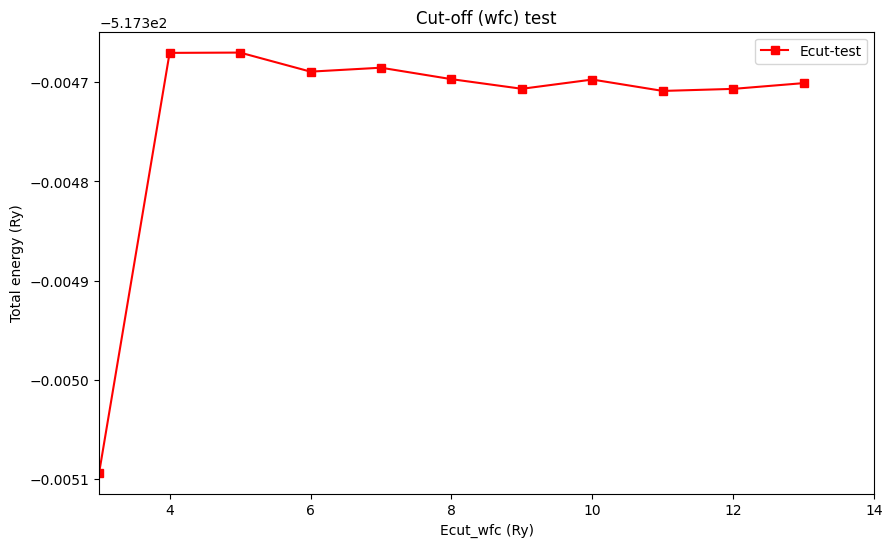

In [166]:
E_rho = np.array(E_rho)
# Create a figure and a set of subplots
fig, ax = plt.subplots( figsize=(10, 6))

# Plot sine wave
ax.plot(E_rho[:,0], E_rho[:,1]/Rydberg,'-s', label='Ecut-test', color='red')

#ax._set_offset(0)

ax.set_xlim(3,14)
#ax.set_ylim(-1,4)
ax.set_title('Cut-off (wfc) test')
ax.set_xlabel('Ecut_wfc (Ry)')
ax.set_ylabel(r'Total energy (Ry)')
ax.legend()

## Optimization

In [167]:
from ase.optimize import BFGS

In [168]:
input_data = {
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': './pseudos',
        'calculation': 'scf',
        'prefix': 'RuO2'
    },
    'system': {
        'ecutwfc': 40,
        'ecutrho': 320,
        'occupations':'smearing',
        'smearing':'gauss',
        'degauss': 0.01
    },
    'electrons': {
        'conv_thr': 1.0e-8, 
        'mixing_beta': 0.7
    },
}

calc = Espresso(
    profile=profile,
    pseudopotentials=pseudopotentials,
    tstress=True,  # deprecated, put in input_data
    tprnfor=True,  # deprecated, put in input_data
    input_data=input_data,
    kpts=(4,4,4),
    koffset=(0,0,0))

In [172]:
# Run Dynamics

RuO2_bulk.calc = deepcopy(calc)
dyn = BFGS(RuO2_bulk,trajectory='relax.traj')
dyn.run(fmax=0.01)

      Step     Time          Energy          fmax
BFGS:    0 21:03:06    -7038.289180        0.000055


True